In [81]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import json
import matplotlib.pyplot as plt
from IPython.display import HTML, Audio
import librosa

In [82]:
def max_over_interval(x, interval=1, sample_rate=44100):
    samples_per_segment = int(sample_rate * interval)
    num_segments = x.shape[0] // samples_per_segment  # Ensure integer division
    max_levels = np.max(np.split(x[:num_segments * samples_per_segment], num_segments), axis=1)
    return max_levels

def viz_audio(x, y=None, interval=1, sample_rate=44100,
                      title='Audio Signal', x_legend='Input' , y_legend='Output',
                      figsize=(10, 4)):
 
    max_levels = max_over_interval(x, interval, sample_rate)
    num_segments = max_levels.shape[0]    
    seconds = np.arange(0, num_segments) * interval
    plt.figure(figsize=figsize)
    plt.plot(seconds, max_levels, marker='o')
    if y is not None:
        max_levels_y = max_over_interval(y, interval, sample_rate)
        plt.plot(seconds, max_levels_y, marker='x', color='red')
        plt.legend([x_legend, y_legend])
    plt.xlabel('Time (s)')
    plt.ylabel('Max Amplitude')
    plt.title(f'Maximum Sound Level per {interval:.1f}s Segment')
    plt.grid(True)
    plt.show()

In [83]:

def load_model_from_json(filename, return_sequences=False):
    with open(filename, 'r') as infile:
        model_dict = json.load(infile)

    input_shape = model_dict['in_shape'][1:]  # Skip the None dimension in the input shape
    model = keras.Sequential()
    model.add(keras.layers.InputLayer(shape=input_shape))

    for layer_info in model_dict['layers']:
        layer_kwargs = {}  # Arguments to pass to the layer constructor

        # Handling common properties
        if 'activation' in layer_info and layer_info['activation']:
            layer_kwargs['activation'] = layer_info['activation']

        # Construct layers based on type
        if layer_info['type'] == 'dense':
            layer = keras.layers.Dense(units=layer_info['shape'][-1], **layer_kwargs)

        elif layer_info['type'] == 'conv1d':
            layer_kwargs.update({
                'filters': layer_info['shape'][-1],
                'kernel_size': layer_info['kernel_size'] if 'kernel_size' in layer_info else 1
            })
            if 'dilation' in layer_info and layer_info['dilation']:
                layer_kwargs['dilation_rate'] = layer_info['dilation']
            if 'groups' in layer_info and layer_info['groups']:
                layer_kwargs['groups'] = layer_info['groups']
            layer = keras.layers.Conv1D(**layer_kwargs)

        elif layer_info['type'] == 'conv2d':
            layer_kwargs.update({
                'filters': layer_info['num_filters_out'],
                'kernel_size': (layer_info['kernel_size_time'], layer_info['kernel_size_feature']),
                'strides': (1, layer_info['strides']) if 'strides' in layer_info else (1, 1),
                'padding': layer_info['padding'] if 'padding' in layer_info else 'valid'
            })
            if 'dilation' in layer_info and layer_info['dilation']:
                layer_kwargs['dilation_rate'] = (layer_info['dilation'], layer_info['dilation'])
            layer = keras.layers.Conv2D(**layer_kwargs)

        elif layer_info['type'] == 'batchnorm' or layer_info['type'] == 'batchnorm2d':
            if 'epsilon' in layer_info:
                layer_kwargs['epsilon'] = layer_info['epsilon']
            layer = keras.layers.BatchNormalization(**layer_kwargs)

        elif layer_info['type'] == 'prelu':
            layer = keras.layers.PReLU()

        elif layer_info['type'] == 'activation':
            layer = keras.layers.Activation(layer_info['activation'])

        elif layer_info['type'] == 'gru' or layer_info['type'] == 'lstm':
            layer_kwargs['units'] = layer_info['shape'][-1]
            layer_kwargs['return_sequences'] = return_sequences 
            if layer_info['type'] == 'gru':
                layer = keras.layers.GRU(**layer_kwargs)
            else:
                layer = keras.layers.LSTM(**layer_kwargs)

        elif layer_info['type'] == 'time-distributed-dense':
            inner_layer = keras.layers.Dense(units=layer_info['shape'][-1], **layer_kwargs)
            layer = keras.layers.TimeDistributed(inner_layer)

        else:
            raise ValueError(f"Unknown layer type: {layer_info['type']}")

        model.add(layer)
        if 'weights' in layer_info:
            layer.set_weights([np.array(w) for w in layer_info['weights']])

    return model


In [84]:
# model_file = 'ht1-target_train_colab_guitar_lstm_36.json'
model_file = 'Ben Vox 441 16bit_colab_guitar_lstm_96.json'
# Let's load the audio file
audio_x_file = 'Ben Direct FP'
# audio_x_file = 'ht1-input_test'
# audio_x_file = 'ht1-input_train'
audio_y_file = 'Ben Vox FP'
# audio_y_file = 'ht1-target_test'
# audio_y_file = 'ht1-target_train'
seconds_to_predict = 20
keras.backend.clear_session()
model = load_model_from_json(model_file, return_sequences=True)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 139, 36)        │           468 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 128, 36)        │        15,588 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128, 96)        │        51,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128, 1)         │            97 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,225 (262.60 KB)

 Trainable params: 67,225 (262.60 KB)

 Non-trainable params: 0 (0.00 B)

In [85]:
x, sample_rate = librosa.load(f'../audio/{audio_x_file}.wav', sr=None, dtype=np.float32)
x = (x / np.max(np.abs(x)))  # Normalize to [-1, 1]
y_gold, _ = librosa.load(f'../audio/{audio_y_file}.wav', sr=None, dtype=np.float32)
y_gold = y_gold / np.max(np.abs(y_gold))  # Normalize to [-1, 1]
print(f"Loded audio files {audio_x_file} and {audio_y_file} with sample rate {sample_rate}")
print(f"Total seconds of audio: {x.shape[0] / sample_rate:.2f}s")

Loded audio files Ben Direct FP and Ben Vox FP with sample rate 44100
Total seconds of audio: 312.00s


In [86]:
# predict x to y
size = sample_rate*seconds_to_predict
x_all = x[:size]
y_pred = model.predict(x_all.reshape(1, -1, 1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


In [87]:
print(f"x_all.shape: {x_all.shape}")
print(f"y_pred.shape: {y_pred.shape}")

x_all.shape: (882000,)
y_pred.shape: (1, 881978, 1)


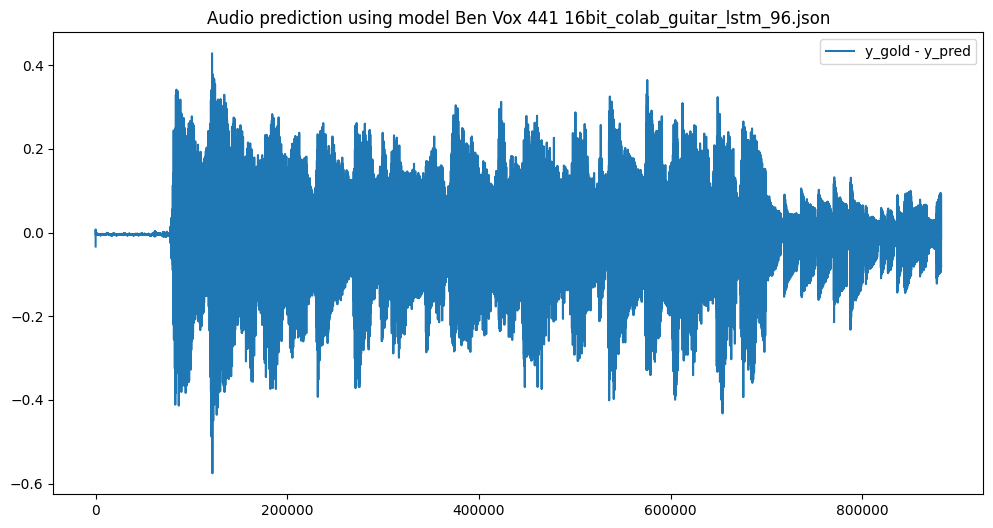

In [88]:
# plot x and y
y_pred_size = y_pred.shape[1]
y_pred_flat = y_pred.flatten()
plt.figure(figsize=(12, 6))
# plt.plot(x_all, label='x')
# plt.plot(y_gold[:y_pred_size], label='y_gold')
# plt.plot(y_pred_flat, label='y_pred')
plt.plot(y_gold[:y_pred_size] - y_pred_flat, label='y_gold - y_pred')
plt.legend()
plt.title(f'Audio prediction using model {model_file}')
plt.show()

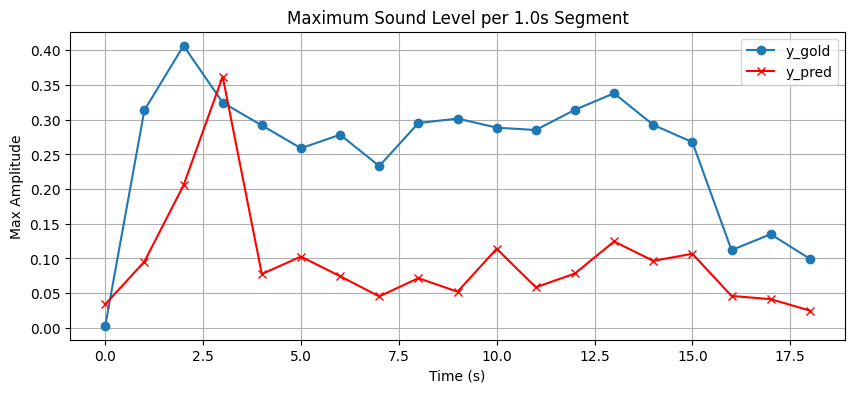

In [89]:
viz_audio(y_gold[:y_pred_size], y_pred_flat, interval=1, sample_rate=sample_rate, x_legend='y_gold', y_legend='y_pred')

In [90]:
# play audio
print("Original audio")
display(Audio(x_all, rate=sample_rate))
print("Predicted audio")
display(Audio(y_pred_flat, rate=sample_rate))
print("Gold audio")
display(Audio(y_gold[:y_pred_size], rate=sample_rate))


Original audio


Predicted audio


Gold audio
